In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import fit, norm, chisquare, goodness_of_fit, lognorm, t,beta, cosine, uniform
from scipy.optimize import curve_fit
from tqdm import tqdm

# Creating the master dataframe

lengthdf = pd.read_csv('..\\Search Area Results\\iteration_1_raw.csv') # we just need this for the length


count = 0
n_bins=10
bin_size = int(len(lengthdf)/n_bins)



rdgprobs = pd.DataFrame()
allprobs = pd.DataFrame(np.array([np.zeros(len(lengthdf))]).T,columns=['CLASS'])
allprobs['sum']=np.zeros(len(allprobs))

# We want to add results from each iteration to a master dataframe

for i in range(1,11):
    df = pd.read_csv('..\\Search Area Results\\iteration_'+str(i)+'_raw.csv')
    rdgprobs['iteration_' +str(i)] = df.loc[df['CLASS1']==3]['y_probs_bll']
    allprobs['iteration_'+str(i)] = df['y_probs_bll']
    allprobs['CLASS_it' +str(i) ]=df['CLASS1']


In [13]:

y_probs=np.empty(len(allprobs))

for iteration in tqdm(range(1,2)):
    y_probs=allprobs['iteration_'+str(iteration)]
    classes=allprobs['CLASS_it' +str(iteration)]

    y_probs_ascending=np.sort(y_probs)
    y_probs_descending=np.flip(y_probs_ascending)


    cutoff_prob_a = np.array([0])
    cutoff_prob_d = np.array([1])
    #print(y_probs_ascending)

    for i in range(0,len(y_probs)):
        count+=1
        if count >= bin_size:
            cutoff_prob_a = np.append(cutoff_prob_a,y_probs_ascending[i])
            cutoff_prob_d = np.append(cutoff_prob_d,y_probs_descending[i])
            count = 0
    n_bins = len(cutoff_prob_a)-1

    bins = pd.DataFrame((np.array([y_probs,classes,np.zeros(len(classes)),np.zeros(len(classes))]).T),
                        columns=['y_probs','classes','bin_n_ascending','bin_n_descending'])

    for i in range(0,n_bins):
        for k in range(0,len(y_probs)):
            if y_probs[k] >= cutoff_prob_a[i] and y_probs[k] < cutoff_prob_a[i+1]:
                bins['bin_n_ascending'][k] = i
            if y_probs[k] <= cutoff_prob_d[i] and y_probs[k] > cutoff_prob_d[i+1]:
                bins['bin_n_descending'][k] = i

    lowerbounds = np.delete(cutoff_prob_a,-1)
    upperbounds = np.delete(cutoff_prob_a,0)
    totals_asc = pd.DataFrame((np.array([np.zeros(n_bins),lowerbounds, upperbounds,np.zeros(n_bins),np.zeros(n_bins),np.zeros(n_bins)]).T),
                                    columns=['Bin (asc)','Lower Bound','Upper Bound','RDG Count','Total Count','Frac'])


    for i in range(0,n_bins): # iterates over each bin in the set
            n_rdg = bins.loc[(bins['bin_n_ascending']==i) & (bins['classes']==3)]
            n_bll = bins.loc[(bins['bin_n_ascending']==i) & (bins['classes']==0)]
            n_fsrq = bins.loc[(bins['bin_n_ascending']==i) & (bins['classes']==1)]
            tot = len(n_rdg)+len(n_bll)+len(n_fsrq)
            #print(f'n_rdg is {len(n_rdg)} from {tot} in ascending bin {i}')
            totals_asc['Bin (asc)'][i] = i
            totals_asc['RDG Count'][i] = len(n_rdg)
            totals_asc['Total Count'][i] = tot
            totals_asc['Frac'][i] = len(n_rdg)/tot

    #totals_asc.to_csv('..\\Search Area Results\\iteration_10')
    #fig, ax = plt.subplots()
    #ax.bar(totals_asc['Bin (asc)'],totals_asc['RDG Count'])
    #ax.set_xlabel('Bin Number')
    #ax.set_ylabel('Fraction of Radio Galaxies')
    totals_asc.to_csv('totals_asc'+str(iteration)+'.csv')


    dummydata = np.array([])

    for i in range(0,len(totals_asc)):
        dummydata = np.append(dummydata,totals_asc['Bin (asc)'][i]*np.ones(int(totals_asc['RDG Count'][i])))

    fittype=beta
    xs = np.arange(0,len(totals_asc),1)
    
    guess = list(beta.fit(dummydata))
    
    fitresults = goodness_of_fit(norm,dummydata,statistic='ks',n_mc_samples=999,guessed_params={'a':guess[0],'b':guess[1],'scale':guess[3]})
    fitresultsdf=pd.DataFrame([[fitresults[0],fitresults[1],fitresults[2]]],columns=['Fit Results','KS Statistic','P-Value'])
    fitresultsdf.to_csv('fit_results_betatest_'+str(iteration)+'.csv')



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


[0. 0. 0. 1. 1. 1. 1. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 7. 7. 7. 7. 7. 7. 8. 8. 8. 9.
 9. 9. 9. 9. 9.]


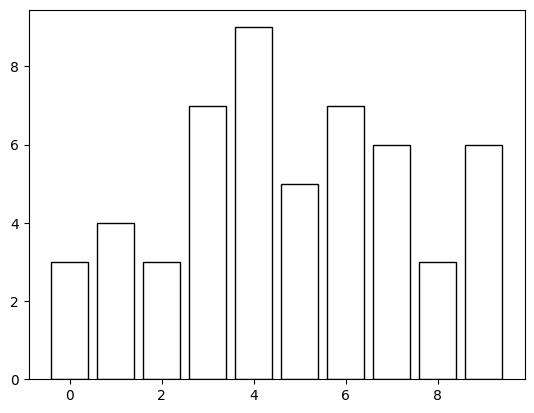

In [15]:
plt.bar(totals_asc['Bin (asc)'],totals_asc['RDG Count'],color='white',edgecolor='black')
print(dummydata)